In [1]:
import sys
sys.path.append('/home/yungdankblast/DelayedOptimization/delay-optimizer')
from FuncOptHandler import Handler
import numpy as np
from Optimizer_Scripts.DelayTypeGenerators import Undelayed, Uniform, Stochastic, Partial
from Optimizer_Scripts.LossFunc import LossFunc
from Optimizer_Scripts.Data import Data

## Check that the new loss function is working as intended

In [2]:
loss = LossFunc("stable", 1)

In [3]:
loss.__dict__

{'loss_name': 'stable',
 'n': 1,
 'loss': <function Optimizer_Scripts.functions.stable_gen.<locals>.stable(x, *args)>,
 'grad': <function Optimizer_Scripts.functions.stable_deriv_gen.<locals>.stable_grad(x, *args)>,
 'domain': [-5, 5],
 'minimizer': array([0.])}

## Try optimizing (250 points in (-5,5))

In [4]:
stable_handler = Handler("stable", 1)

In [5]:
stable_handler.random_points(250)

In [6]:
stable_handler.x_inits.shape    # Generated correctly

(250, 1)

In [7]:
undel_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "const",
    learning_rate = .6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 29.35it/s]


In [8]:
del_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "const",
    learning_rate = .6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 27.68it/s]


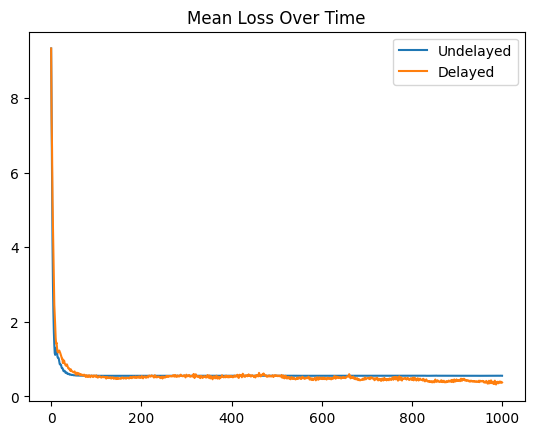

In [79]:
from matplotlib import pyplot as plt

plt.plot(np.mean(undel_data.get_loss_array(), axis=0), label="Undelayed")
plt.plot(np.mean(del_data.get_loss_array(), axis=0), label="Delayed")
plt.title("Mean Loss Over Time")
plt.legend()
plt.show()

In [61]:
def get_state_arr(data):    # 1D function only
    state_arr = np.empty([len(data.state_vals), data.maxiter+1])
    for j, state_vals in enumerate(data.state_vals):
        state_vals = state_vals.flatten()
        state_arr[j][:len(state_vals)] = state_vals
        state_arr[j][len(state_vals):] = state_vals[-1]
    
    return state_arr  

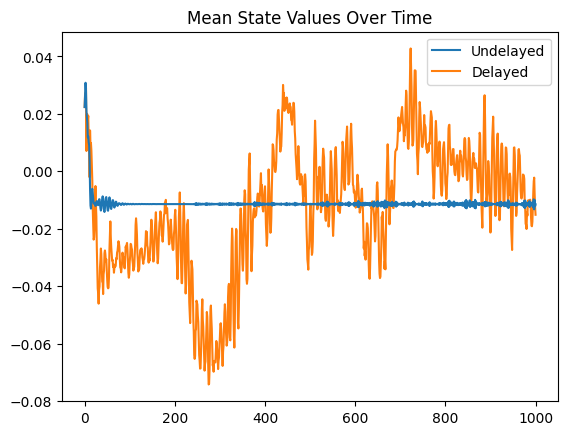

In [60]:
plt.plot(np.mean(get_state_arr(undel_data), axis=0), zorder=10, label="Undelayed")
plt.plot(np.mean(get_state_arr(del_data), axis=0), zorder=5, label="Delayed")
plt.title("Mean State Values Over Time")
plt.legend()
plt.show()

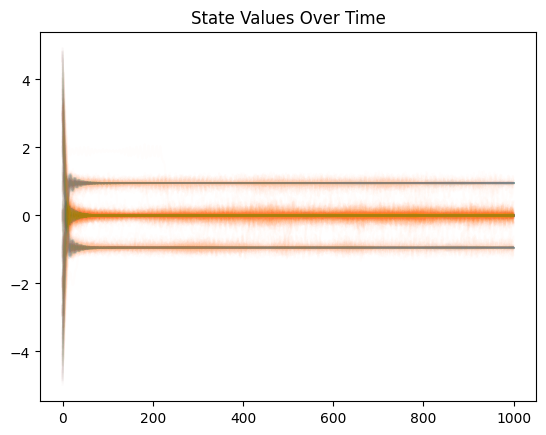

In [63]:
plt.plot(get_state_arr(undel_data).T, label="Undelayed", color="C0", alpha=0.01)
plt.plot(get_state_arr(del_data).T, label="Delayed", color="C1", alpha=0.01)
plt.title("State Values Over Time")
plt.show()

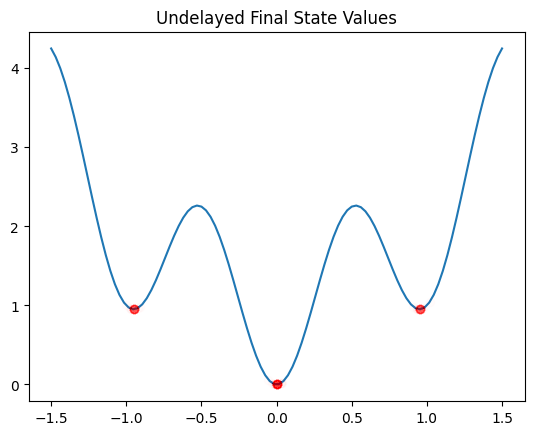

In [68]:
x = np.linspace(-1.5,1.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(undel_data.get_finals(undel_data.state_vals), undel_data.get_finals(undel_data.loss_vals), label="Undelayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Undelayed Final State Values")
plt.show()

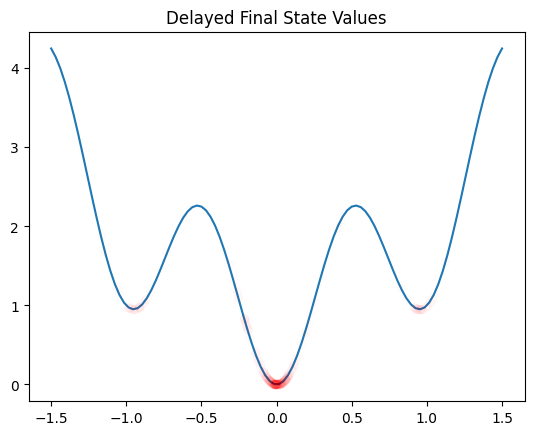

In [69]:
x = np.linspace(-1.5,1.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(del_data.get_finals(del_data.state_vals), del_data.get_finals(del_data.loss_vals), label="Delayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Delayed Final State Values")
plt.show()

## Try with Decaying Learning Rate

##### Linear

In [75]:
undel_linear_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "linear",
    max_lr = 3,
    min_lr = 0,
    num_steps = 1000,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 28.53it/s]


In [76]:
del_linear_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "linear",
    max_lr = 3,
    min_lr = 0,
    num_steps = 1000,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 25.58it/s]


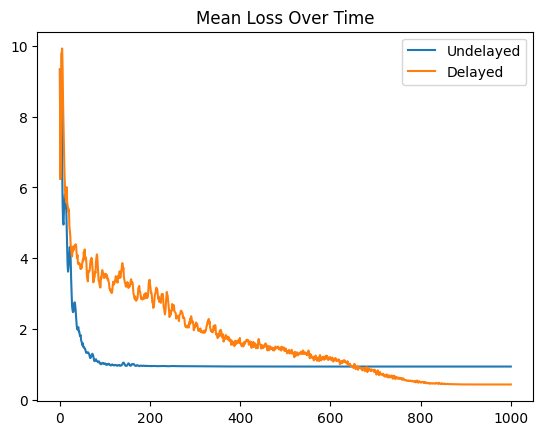

In [78]:
undel_mean_losses = np.mean(undel_linear_data.get_loss_array(), axis=0)
del_mean_losses = np.mean(del_linear_data.get_loss_array(), axis=0)

plt.plot(undel_mean_losses, label="Undelayed")
plt.plot(del_mean_losses, label="Delayed")
plt.title("Mean Loss Over Time")
plt.legend()
plt.show()

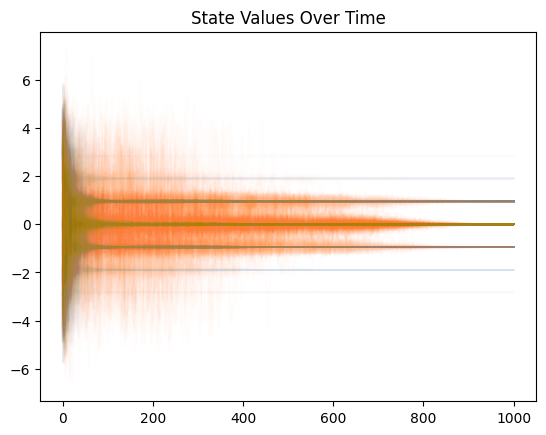

In [80]:
plt.plot(get_state_arr(undel_linear_data).T, label="Undelayed", color="C0", alpha=0.01)
plt.plot(get_state_arr(del_linear_data).T, label="Delayed", color="C1", alpha=0.01)
plt.title("State Values Over Time")
plt.show()

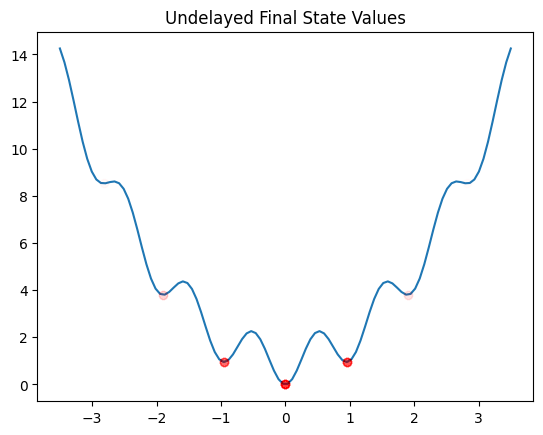

In [85]:
x = np.linspace(-3.5,3.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(undel_linear_data.get_finals(undel_linear_data.state_vals), undel_linear_data.get_finals(undel_linear_data.loss_vals), label="Undelayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Undelayed Final State Values")
plt.show()

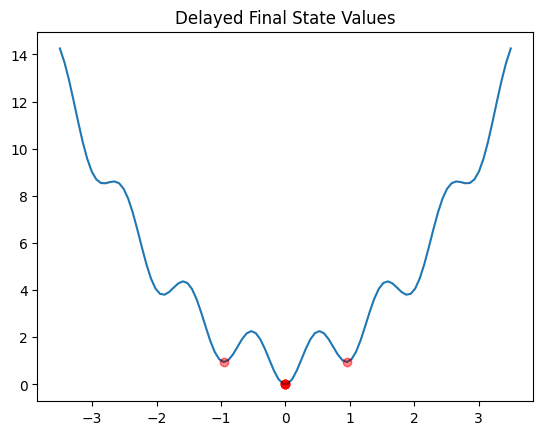

In [86]:
x = np.linspace(-3.5,3.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(del_linear_data.get_finals(del_linear_data.state_vals), del_linear_data.get_finals(del_linear_data.loss_vals), label="Delayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Delayed Final State Values")
plt.show()

##### Inverse-Time

In [88]:
undel_inv_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:09<00:00, 27.20it/s]


In [90]:
del_inv_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 26.80it/s]


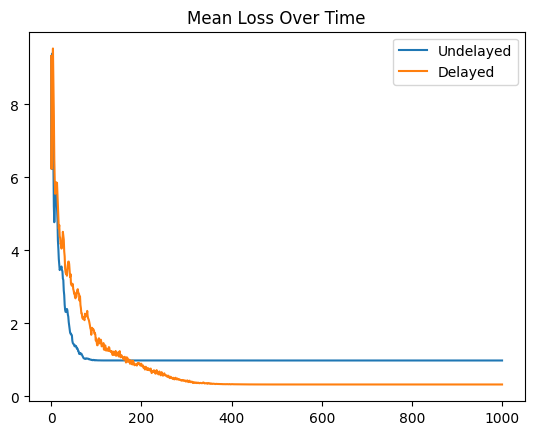

In [91]:
undel_mean_losses = np.mean(undel_inv_data.get_loss_array(), axis=0)
del_mean_losses = np.mean(del_inv_data.get_loss_array(), axis=0)

plt.plot(undel_mean_losses, label="Undelayed")
plt.plot(del_mean_losses, label="Delayed")
plt.title("Mean Loss Over Time")
plt.legend()
plt.show()

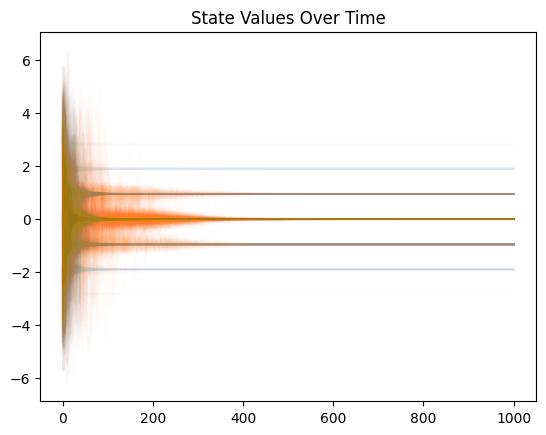

In [92]:
plt.plot(get_state_arr(undel_inv_data).T, label="Undelayed", color="C0", alpha=0.01)
plt.plot(get_state_arr(del_inv_data).T, label="Delayed", color="C1", alpha=0.01)
plt.title("State Values Over Time")
plt.show()

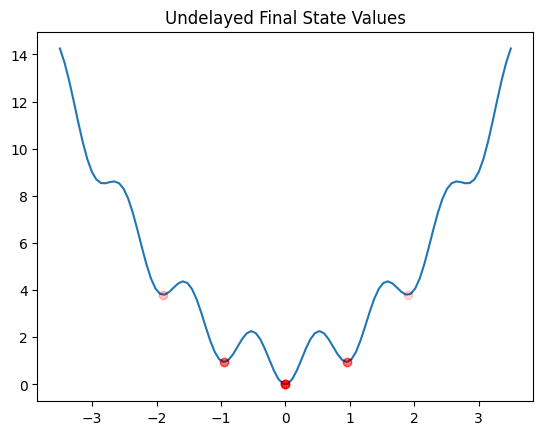

In [93]:
x = np.linspace(-3.5,3.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(undel_inv_data.get_finals(undel_inv_data.state_vals), undel_inv_data.get_finals(undel_inv_data.loss_vals), label="Undelayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Undelayed Final State Values")
plt.show()

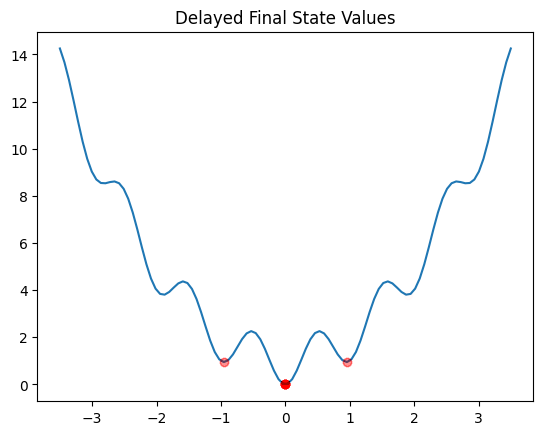

In [94]:
x = np.linspace(-3.5,3.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(del_inv_data.get_finals(del_inv_data.state_vals), del_inv_data.get_finals(del_inv_data.loss_vals), label="Delayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Delayed Final State Values")
plt.show()

##### Local Nature

In [103]:
x_inits = np.random.uniform(-.05, .05, 250).reshape(-1,1)
stable_handler.load_points(x_inits)

In [104]:
undel_loc_inv_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 28.81it/s]


In [105]:
del_loc_inv_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 27.10it/s]


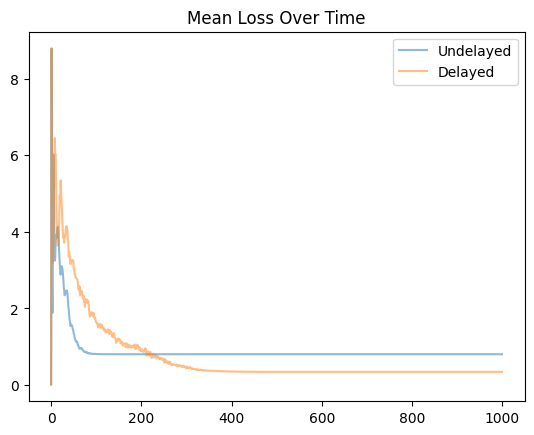

In [110]:
undel_mean_losses = np.mean(undel_loc_inv_data.get_loss_array(), axis=0)
del_mean_losses = np.mean(del_loc_inv_data.get_loss_array(), axis=0)

plt.plot(undel_mean_losses, label="Undelayed", alpha=0.5)
plt.plot(del_mean_losses, label="Delayed", alpha=0.5)
plt.title("Mean Loss Over Time")
plt.legend()
plt.show()

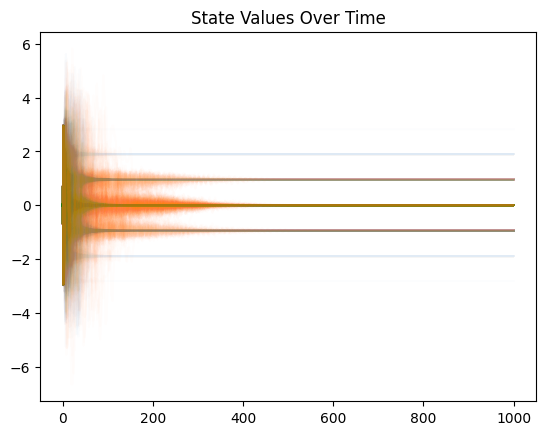

In [109]:
plt.plot(get_state_arr(undel_loc_inv_data).T, label="Undelayed", color="C0", alpha=0.01)
plt.plot(get_state_arr(del_loc_inv_data).T, label="Delayed", color="C1", alpha=0.01)
plt.title("State Values Over Time")
plt.show()

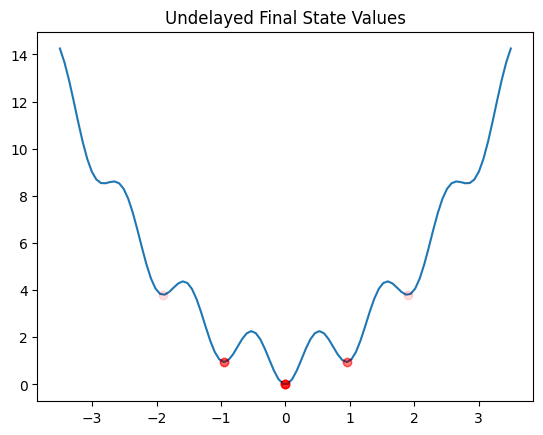

In [112]:
x = np.linspace(-3.5,3.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(undel_loc_inv_data.get_finals(undel_loc_inv_data.state_vals), undel_loc_inv_data.get_finals(undel_loc_inv_data.loss_vals), label="Undelayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Undelayed Final State Values")
plt.show()

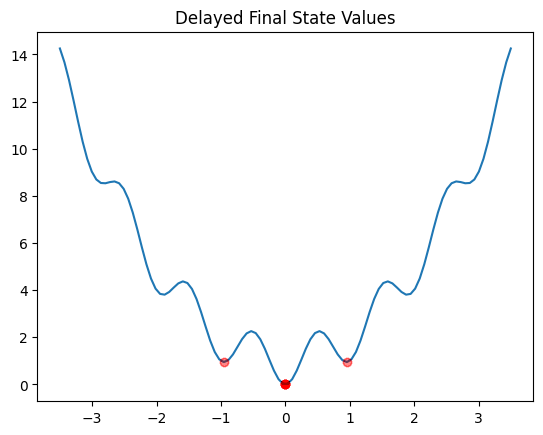

In [113]:
x = np.linspace(-3.5,3.5,100)
y = [loss.loss(np.array([val])) for val in x]

plt.plot(x, y, label="Loss Function")
plt.scatter(del_loc_inv_data.get_finals(del_loc_inv_data.state_vals), del_loc_inv_data.get_finals(del_loc_inv_data.loss_vals), label="Delayed Final States", color="red", alpha=0.01, zorder=10)
plt.title("Delayed Final State Values")
plt.show()